In [1]:
import sys
directory_path = "../"
if directory_path not in sys.path:
    # Add the directory to sys.path
    sys.path.append(directory_path)

import copy
import time
import time
import numpy as np
import argparse

from torch.utils import data

from utils.utils import *
from utils import load_config
from utils.validate import *
from fedlearning.model import *
from fedlearning.dataset import *
from fedlearning.evolve import *
from fedlearning.optimizer import GlobalUpdater, LocalUpdater, get_omegas
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

In [2]:
config_file = "config_random_graph.yaml"
config = load_config(config_file)

logger = init_logger(config)

model = init_model(config, logger)

record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

--------------------------------------------------------------------------------


In [3]:
record

{'num_parameters': 79510,
 'batch_size': 600,
 'lr': 0.01,
 'taus': [],
 'testing_accuracy': [],
 'loss': [],
 'rounds': 10,
 'iid': True,
 'model_accs_per_round': [],
 'model_num_training_rounds': [],
 'epoch': 0}

## Training Dissection

In [4]:
user_ids = np.arange(0, config.users)
num_participators = int(config.part_rate*config.users) 

In [5]:
user_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

Set according to part rate

In [6]:
num_participators

100

In [7]:
dataset = assign_user_data(config, logger)

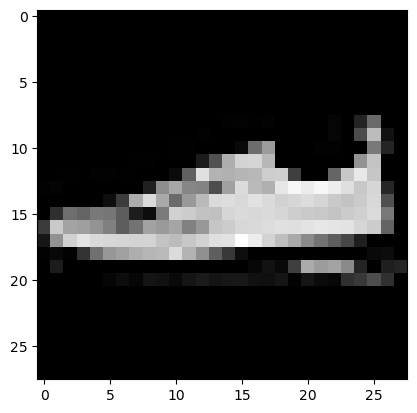

In [8]:
rand_idx = np.random.randint(dataset["train_data"]["images"].shape[0])
plt.imshow(dataset["train_data"]["images"][rand_idx].reshape(28, 28), cmap='gray')

In [9]:
dataset["train_data"]["images"].shape

(60000, 784)

NOTE: When the premade non-iid user_with_data is used, kai has already recided on the number of users being 300.

Histogram of number of samples per user. Looks like they are very similar! This is not representative of the actual non iid setting... does this make a difference? Also about all samples are used.

Number of values: 28512
Highest value: 28511
Lowest value: 0


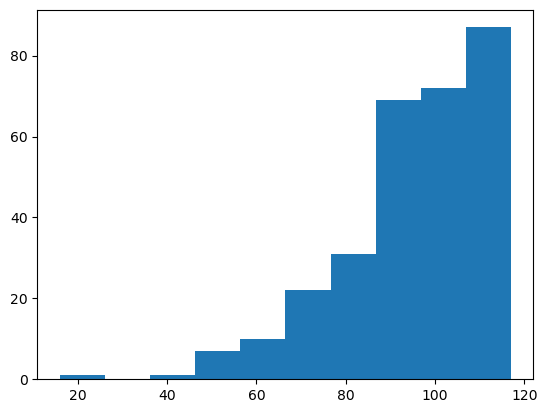

In [77]:
# Assuming the list of NumPy arrays is stored in the variable 'array_list'
array_list = list(dataset["user_with_data"].values())

num_values = sum(len(arr) for arr in array_list)
highest_value = np.max(np.concatenate(array_list))
lowest_value = np.min(np.concatenate(array_list))


print("Number of values:", num_values)
print("Highest value:", highest_value)
print("Lowest value:", lowest_value)
plt.hist([len(arr) for arr in array_list], bins=10); plt.show()

### Number of repeated images in the clients. Not sure if sampling without replacement should have been done, or if this is ok...

In [78]:
np.sum((np.unique(np.concatenate(array_list), return_counts=True)[1]>1))

0

In [63]:
dataset

{'train_data': {'images': array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
          -0.42421296, -0.42421296],
         [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
          -0.42421296, -0.42421296],
         [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
          -0.42421296, -0.42421296],
         ...,
         [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
          -0.42421296, -0.42421296],
         [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
          -0.42421296, -0.42421296],
         [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
          -0.42421296, -0.42421296]], dtype=float32),
  'labels': array([[0., 1., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)},
 'test_data': {'images': array([[-0.424

Kernel 1: 70,560,000 bytes

In [64]:
model

NaiveMLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [65]:
model = model.to(config.device)

In [35]:
output = model(torch.from_numpy(dataset["train_data"]["images"]).to(config.device).float())

In [36]:
y = torch.from_numpy(dataset["train_data"]["labels"]).to(config.device)

In [37]:
output.shape

torch.Size([60000, 10])

In [38]:
torch.nn.functional.cross_entropy(output, y)

tensor(3.3228, device='cuda:0', grad_fn=<DivBackward1>)

In [39]:
with torch.no_grad():
        model.eval()
        test_output = model(torch.from_numpy(dataset["test_data"]["images"]).to(config.device).float())
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = torch.sum(pred_y == torch.argmax(torch.from_numpy(dataset["test_data"]["labels"]).to(config.device), dim=1)).type(torch.FloatTensor) / torch.from_numpy(dataset["test_data"]["labels"]).shape[0]
        print(f"Test Accuracy: {accuracy.item()}")
        model.train()

Test Accuracy: 0.03099999949336052


In [44]:
import torch
import torch.nn.functional as F

# Assuming 'model' is the model you want to optimize
# Assuming 'dataset' is the dictionary containing the training data

# Set the model to training mode
model.train()

# Define the optimizer (e.g., SGD, Adam, etc.)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the number of training iterations
num_iterations = 1000

# Loop over the training data for the specified number of iterations
for iteration in range(num_iterations):
    # Clear the gradients
    optimizer.zero_grad()
    
    # Forward pass: compute the predicted outputs
    outputs = model(torch.from_numpy(dataset["train_data"]["images"]).to(config.device).float())
    
    # Compute the cross entropy loss
    loss = F.cross_entropy(outputs, torch.argmax(torch.from_numpy(dataset["train_data"]["labels"]).to(config.device), dim=1))
    print(f"Loss: {loss.item()}")    

    # Backward pass: compute the gradients
    loss.backward()
    
    # Update the model parameters
    optimizer.step()

with torch.no_grad():
        model.eval()
        test_output = model(torch.from_numpy(dataset["test_data"]["images"]).to(config.device).float())
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = torch.sum(pred_y == torch.argmax(torch.from_numpy(dataset["test_data"]["labels"]).to(config.device), dim=1)).type(torch.FloatTensor) / torch.from_numpy(dataset["test_data"]["labels"]).shape[0]
        print(f"Test Accuracy: {accuracy.item()}")
        model.train()

Loss: 0.41095197200775146
Loss: 0.4109157919883728
Loss: 0.4108794629573822
Loss: 0.4108433723449707
Loss: 0.4108071029186249
Loss: 0.41077080368995667
Loss: 0.41073450446128845
Loss: 0.4106985032558441
Loss: 0.41066229343414307
Loss: 0.4106261730194092
Loss: 0.4105900526046753
Loss: 0.41055402159690857
Loss: 0.41051799058914185
Loss: 0.4104819893836975
Loss: 0.4104459881782532
Loss: 0.4104100167751312
Loss: 0.41037389636039734
Loss: 0.4103379547595978
Loss: 0.41030174493789673
Loss: 0.4102657437324524
Loss: 0.41022974252700806
Loss: 0.41019368171691895
Loss: 0.41015779972076416
Loss: 0.410121887922287
Loss: 0.4100860059261322
Loss: 0.41005027294158936
Loss: 0.4100143015384674
Loss: 0.4099784791469574
Loss: 0.4099426865577698
Loss: 0.40990668535232544
Loss: 0.4098709225654602
Loss: 0.4098350405693054
Loss: 0.4097994565963745
Loss: 0.4097635746002197
Loss: 0.40972772240638733
Loss: 0.4096919298171997
Loss: 0.4096563756465912
Loss: 0.40962058305740356
Loss: 0.4095850884914398
Loss: 0.409

In [41]:
with torch.no_grad():
    model.eval()
    output = model(torch.from_numpy(dataset["test_data"]["images"]).to(config.device).float())
    y = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)
    loss = torch.nn.functional.cross_entropy(output, y)
    print("Loss:", loss.item())
    

Loss: 0.5003145933151245


In [7]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import os
# Unload the pickle file
filepath = "./utils/results"

lr: 0.01, alpha: 0.1

In [17]:
def plot_accuracy(fnames, alphas=None): 
    if type(fnames) == str:
        fnames = [fnames]
    
    assert type(fnames) == list
    
    max_acc = 0
    
    for fname, alpha in zip(fnames, alphas):
        with open(fname, 'rb') as file:
            fmnist = pickle.load(file)
        plt.plot(fmnist["testing_accuracy"], label=f"alpha={alpha}")
        max_acc = max(max_acc, max(fmnist["testing_accuracy"]))
    print(f"Max Accuracy: {max_acc}")
    plt.legend()
    plt.title(f"Testing Accuracy vs Communication Round, lr = {fmnist['lr']}")

    plt.xlabel("Communication Round")
    plt.ylabel("Testing Accuracy")
    plt.xticks(np.arange(0,fmnist["rounds"],3))   

    # Show the plot
    plt.show()


## lr 0.01

Max Accuracy: 0.8565999865531921


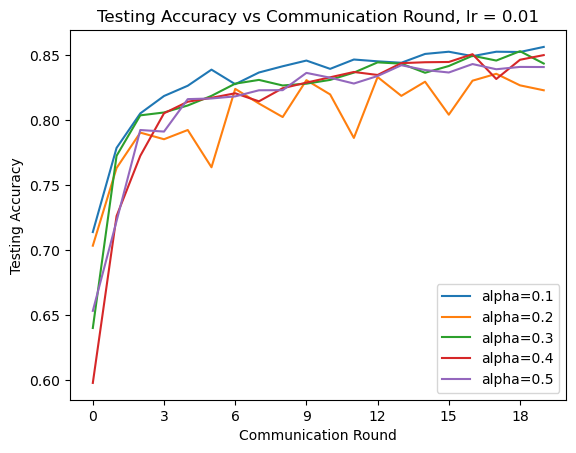

In [40]:
fnames = [os.path.join(filepath, f"lr0.01/alpha0.{i}.dat") for i in range(1, 6)]
plot_accuracy(fnames, alphas=[0.1, 0.2, 0.3, 0.4, 0.5])

## lr 0.001

Max Accuracy: 0.8445000052452087


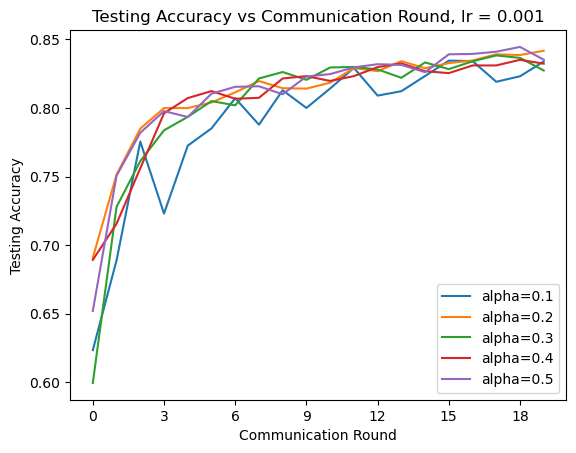

In [41]:
fnames = [os.path.join(filepath, f"lr0.001/alpha0.{i}.dat") for i in range(1, 6)]
plot_accuracy(fnames, alphas=[0.1, 0.2, 0.3, 0.4, 0.5])

## lr 0.1

Max Accuracy: 0.8271999955177307


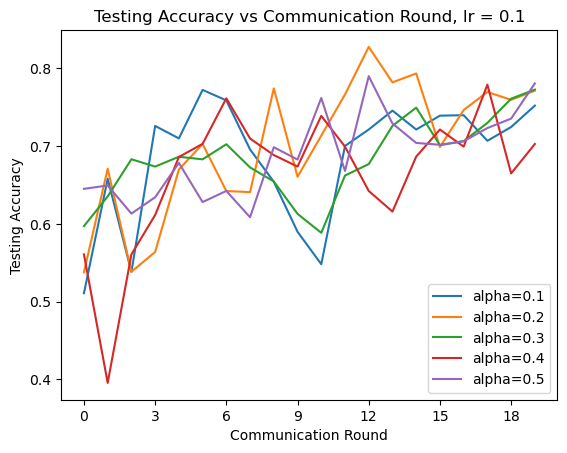

In [42]:
fnames = [os.path.join(filepath, f"lr0.1/alpha0.{i}.dat") for i in range(1, 6)]
plot_accuracy(fnames, alphas=[0.1, 0.2, 0.3, 0.4, 0.5])

## lr 0.01, IID

Max Accuracy: 0.852899968624115


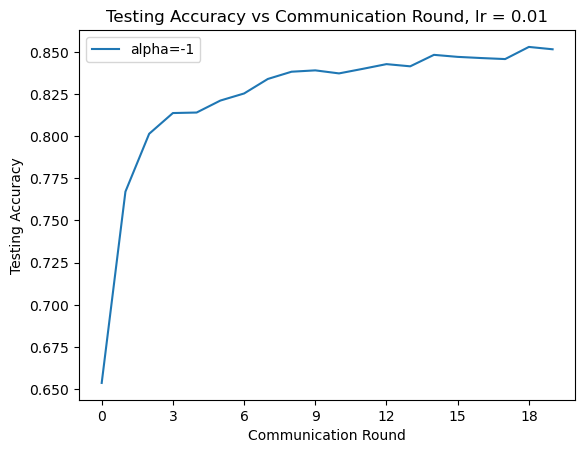

In [43]:
fname = "./iid_FAMNIST.dat"
plot_accuracy(fname, alphas=[-1])
    

# CLUSTER RESULTS

## Trial 7 - $\alpha=0.1$, cluster size 5

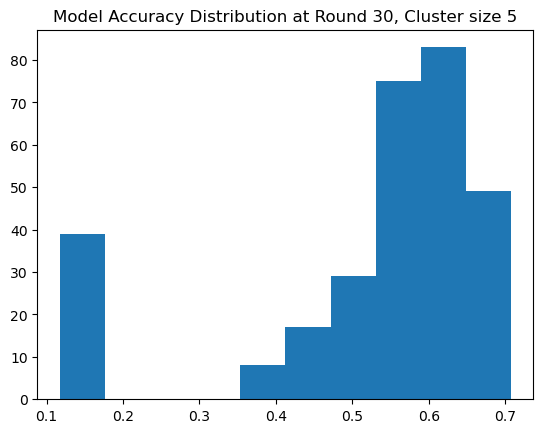

In [52]:
plot_acc_hist(7, 29, 5)

## Trial 9 - $\alpha=0.1$, cluster size 3

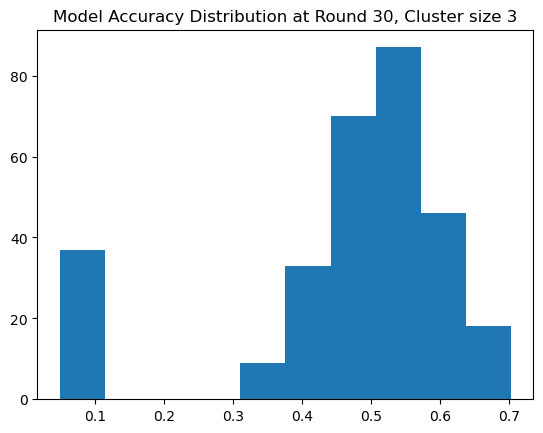

In [54]:
plot_acc_hist(9, 29, 3)

In [3]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import os
# Unload the pickle file
filepath = "../records/12_06_18_52.dat"
def open_dat(fp):
    with open(fp, 'rb') as file:
        log = pickle.load(file)
        return log
    
rec = open_dat(filepath)

In [7]:
np.asarray(rec["loss"]).mean(axis=1)[3:]

array([0.61833511, 0.39362429, 0.33624491, 0.31007393, 0.28996674,
       0.27645771, 0.26382018, 0.25286293, 0.25716072, 0.24178595])

In [11]:
np.asarray(rec["testing_accuracy"]).mean(axis=1)[3:]

array([0.71925765, 0.78234565, 0.80053098, 0.80957598, 0.81536698,
       0.81959531, 0.82238765, 0.82419131, 0.82815464, 0.82976998])

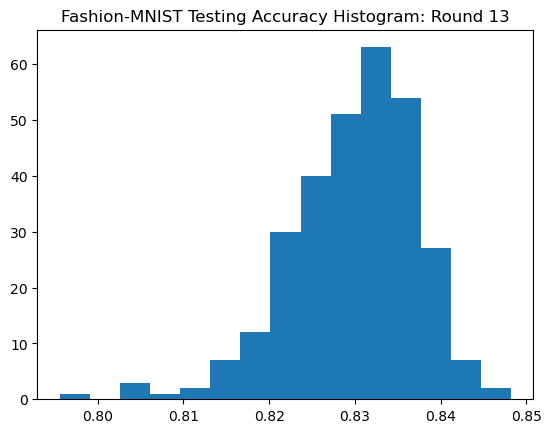

In [19]:
def plot_hist(record, metric, dataset_name, round):
    plt.hist(record[metric][round], bins=15)
    plt.title(f"{dataset_name} Testing Accuracy Histogram: Round {round+1}")
    plt.show()
plot_hist(rec, "testing_accuracy", "Fashion-MNIST", 12)

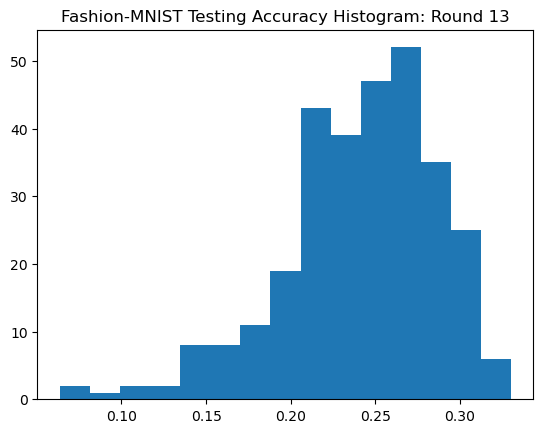

In [22]:
plot_hist(rec, "loss", "Fashion-MNIST", 12)

In [8]:
save_record(config, rec)

NameError: name '__file__' is not defined

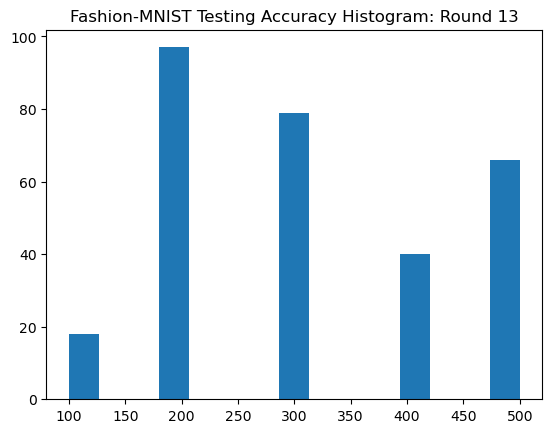

In [28]:
plot_hist(rec, "taus", "Fashion-MNIST", 12)